# Supported Vector Machine

# !!!!!!!!! Criar csvs limpos para testar depois !!!!!!!!!!!

# Base Idea: [link to study](https://pubs.aip.org/aip/acp/article-abstract/2655/1/020103/2888254/Classification-of-normal-and-nodule-lung-images?redirectedFrom=fulltext)

This code utilizes a Support Vector Machine (SVM) for classification of data extracted from the LIDC-IDRI dataset.

The `.csv` file employed in this version contains a **clean and analyzed** dataset derived from the raw data using the `pylidc`, `pyradiomics`, and deep feature extraction methods.

The relevant methods can be found in the **csv_cleanup** folder.

## Importing libraries and Datasets

We will begin by importing the relevant and necessary libraries.

In [44]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [45]:
%matplotlib inline

Next, we will convert the three datasets into pandas DataFrames for further processing.

In [46]:
df = pd.read_csv('2d_corr.csv')
#df = pd.read_csv('semi_clean_cnn.csv')
df.head()

,patient_nodule_count,is_cancer,radiomics_original_shape_LeastAxisLength,radiomics_original_shape_MajorAxisLength,radiomics_original_shape_Maximum2DDiameterColumn,radiomics_original_shape_Maximum2DDiameterRow,radiomics_original_shape_Maximum2DDiameterSlice,radiomics_original_shape_Maximum3DDiameter,radiomics_original_shape_MinorAxisLength,radiomics_original_shape_SurfaceVolumeRatio,radiomics_original_gldm_LargeDependenceEmphasis,radiomics_original_glrlm_RunEntropy
0,1,2,19.588162,22.827597,31.038346,32.075141,26.977005,34.406945,22.206076,0.368609,541.648121,3.473935
1,1,2,21.632902,28.944112,36.659875,30.945300,37.724947,40.384819,23.027779,0.388414,602.337075,4.231633
2,1,0,14.561133,26.516200,26.873199,31.855156,25.552264,32.630357,20.380759,0.472904,464.245476,3.180046
3,2,2,16.647824,24.114835,26.959597,30.922607,24.750701,30.922607,20.180327,0.361115,529.237581,3.246592
4,3,2,7.316637,11.451529,11.145619,12.548361,12.934109,13.267970,7.644348,0.816013,335.911877,2.094209


In [47]:
# One hot encoding
df_encoded = df.copy()

# Select only columns with floating-point values
float_columns = df_encoded.select_dtypes(include='float').columns

# Define function to apply one-hot encoding for quantile-based intervals
def one_hot_encode_quantile_intervals(column, quantiles):
    # Get the quantile boundaries for the column
    quantile_values = df_encoded[column].quantile(quantiles).values
    
    # Create an empty DataFrame to store one-hot encoded columns
    encoded_df = pd.DataFrame()
    
    # Create binary columns for each interval based on quantiles
    for i in range(len(quantile_values) - 1):
        low = quantile_values[i]
        high = quantile_values[i + 1]
        encoded_df[f'{column}_interval_{i}'] = df_encoded[column].apply(lambda x: 1 if low <= x < high else 0)
    
    return encoded_df

# Iterate over each floating point column and apply one-hot encoding based on quantile intervals
for column in float_columns:
    # Define quantiles for dividing the data into intervals
    # (You can adjust the quantiles as desired)
    quantiles = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    # Apply one-hot encoding for this column
    encoded_intervals_df = one_hot_encode_quantile_intervals(column, quantiles)
    
    # Drop the original floating-point column and concatenate the new one-hot encoded columns
    df_encoded = df_encoded.drop(columns=[column]).join(encoded_intervals_df)

# Now df_encoded contains one-hot encoded columns for each floating-point column based on quantile intervals.


In [48]:
# Step 2: Extract features (X) and labels (y)
# Assume df contains the feature columns and a label column
X = df.drop(columns=['is_cancer'])  # Drop the label column to get features
y = df['is_cancer']  # Target variable (lung nodule classification)

X_enc = df_encoded.drop(columns=['is_cancer'])  # Drop the label column to get features
y_enc = df_encoded['is_cancer']  # Target variable (lung nodule classification)

### Scatterplot for Analysis

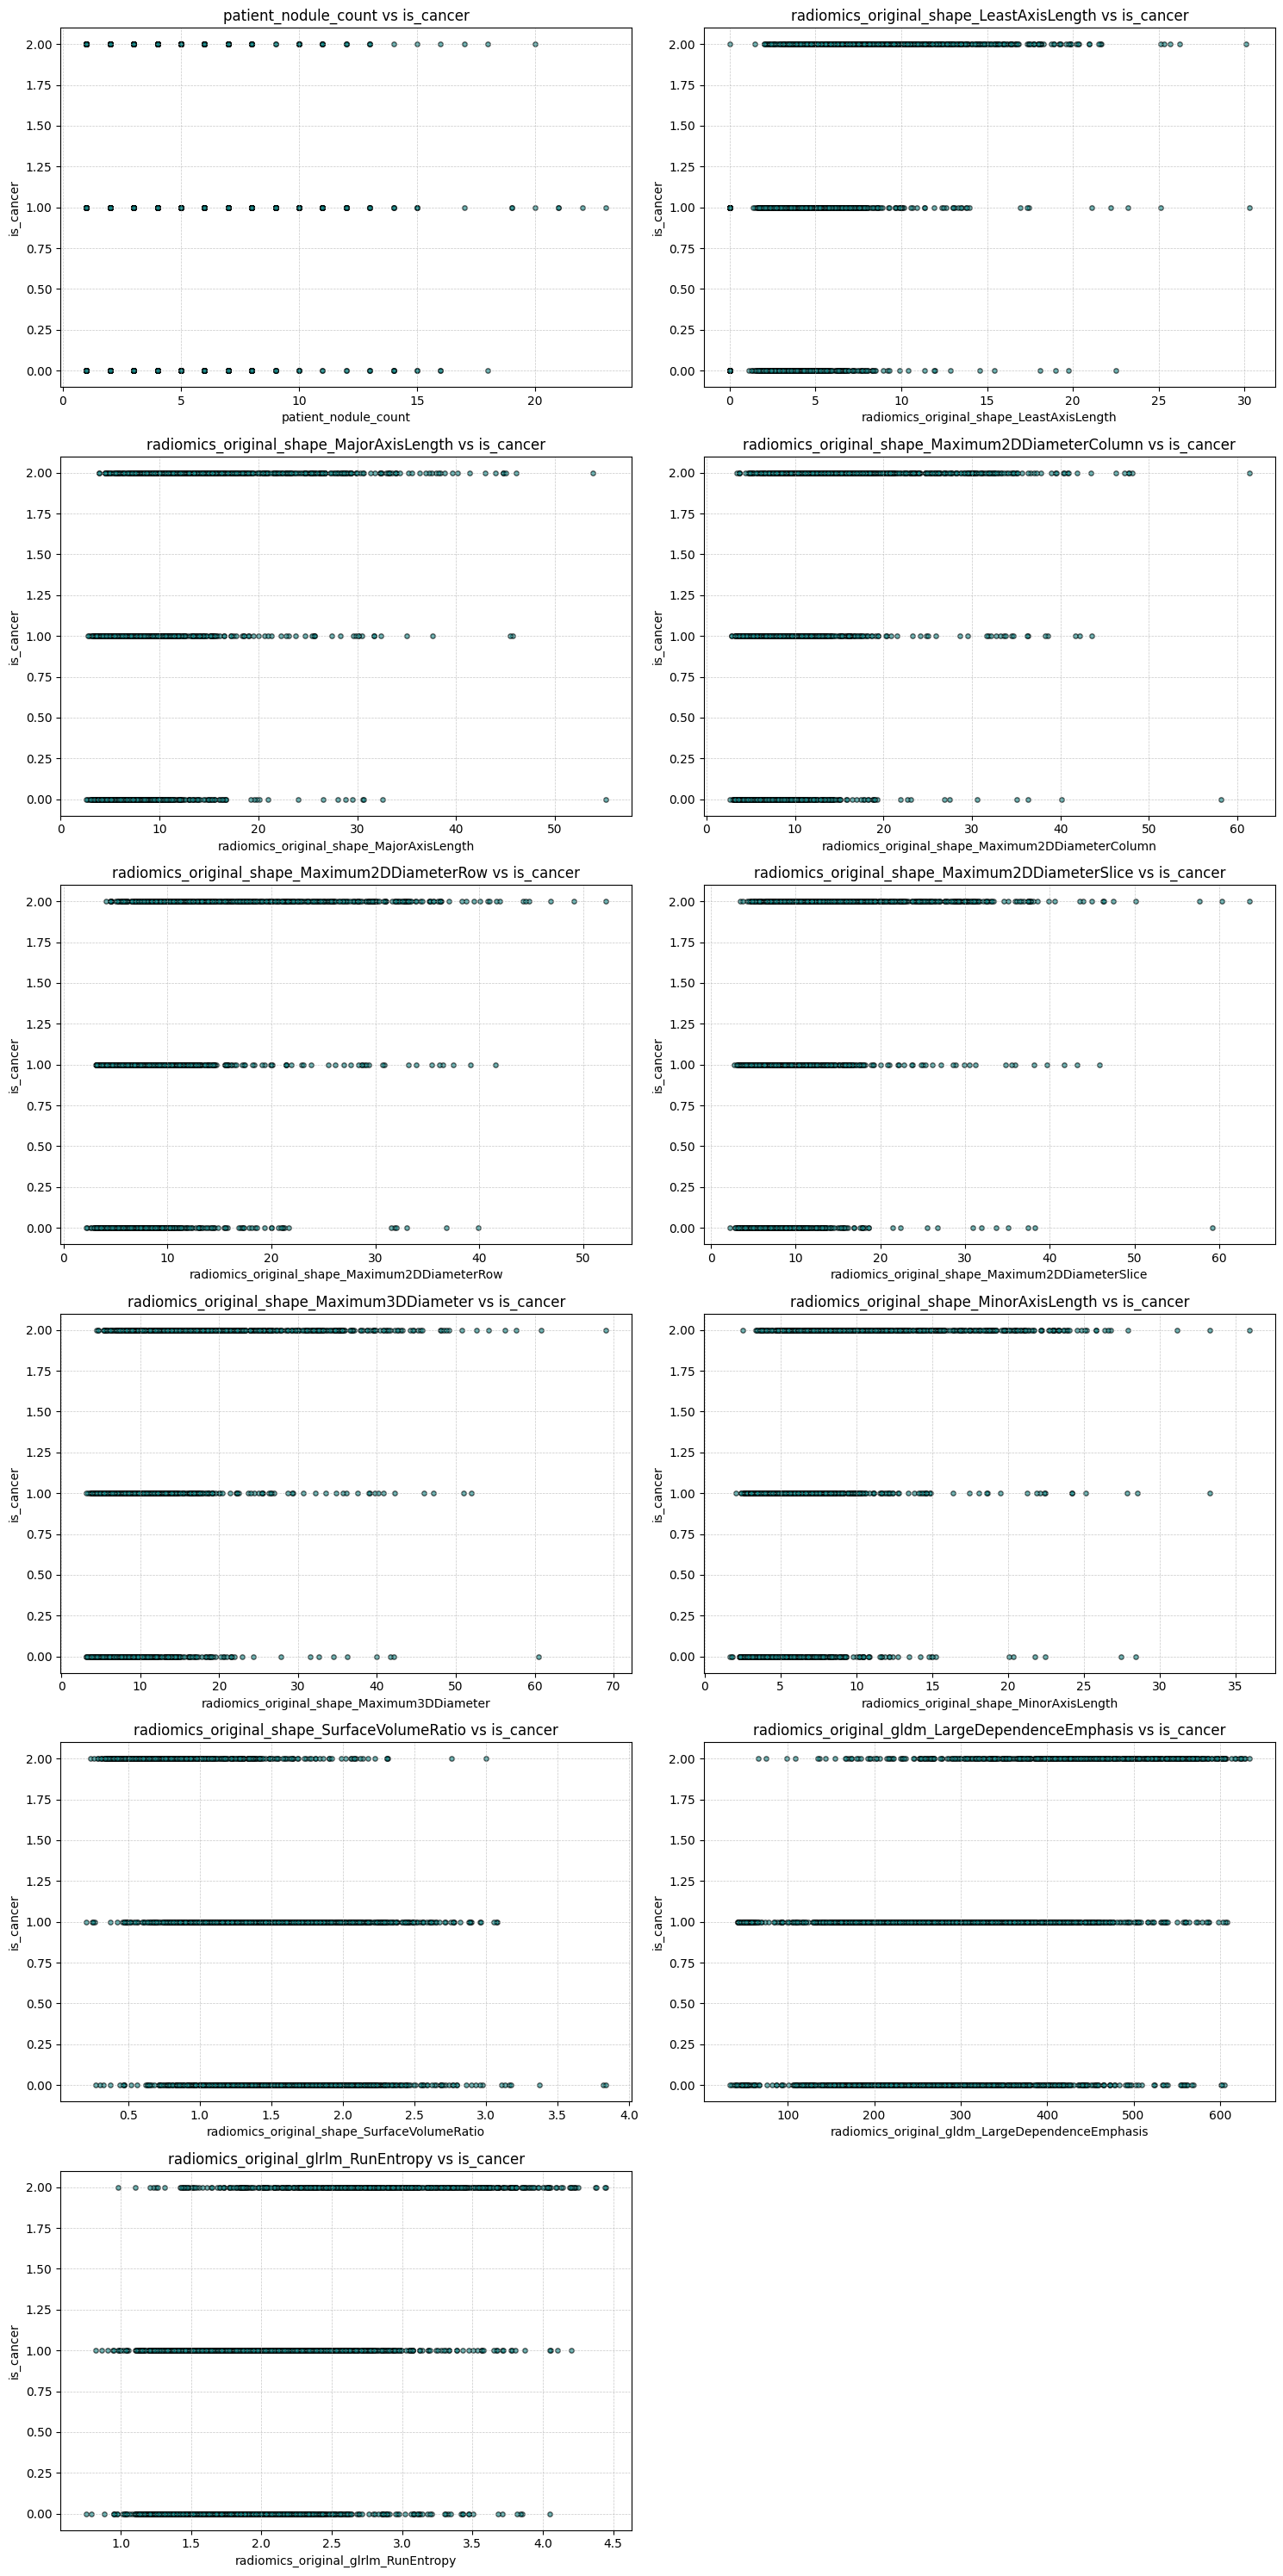

In [49]:
target = 'is_cancer'
features = [col for col in df.columns if col != target]

import seaborn as sns

# Using seaborn's color palette for a visually distinct color scheme
sns.set_palette("Set2")

# Setting up a larger figure and adjusting the number of columns for clarity
n_cols = 2  # Change number of columns to 2 for easier reading
n_rows = (len(features) + 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))

# Generate scatter plots with enhancements
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(df[feature], df[target], color='teal', alpha=0.6, edgecolor='k', s=15)
    plt.title(f'{feature} vs {target}', fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel(target, fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [50]:
# Step 3: Data preprocessing (scaling)
# SVM performs better when features are standardized
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit to the data and then transform it

X_scaled_enc = scaler.fit_transform(X_enc)  # Fit to the data and then transform it

In [51]:

# Step 4: Setting up the SVM model
# We will use a basic SVM with an RBF kernel (commonly used for medical data)
svm_model = SVC(kernel='sigmoid', C=1, gamma='scale')  # Regularization and kernel hyperparameters


In [52]:

# Step 5: Performing 10-fold cross-validation
# Define KFold with 10 splits
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [53]:
# Cross-validation to get the score for each fold
cv_scores = cross_val_score(svm_model, X_scaled, y, cv=kfold, scoring='accuracy')

# Output the results
print(f"Cross-validation accuracy scores for each fold: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores)}")
print(f"Standard deviation of accuracy: {np.std(cv_scores)}")

print('-------------------------------------------------------')

svm_model = SVC(kernel='sigmoid', C=1, gamma='scale')  # Regularization and kernel hyperparameters
cv_scores = cross_val_score(svm_model, X_scaled_enc, y_enc, cv=kfold, scoring='accuracy')

# Output the results
print(f"Cross-validation accuracy scores for each fold: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores)}")
print(f"Standard deviation of accuracy: {np.std(cv_scores)}")

Cross-validation accuracy scores for each fold: [0.48301887 0.41509434 0.4469697  0.4469697  0.43181818 0.46590909
 0.46212121 0.48106061 0.45454545 0.45833333]
Mean accuracy: 0.4545840480274442
Standard deviation of accuracy: 0.019754365580012784
-------------------------------------------------------
Cross-validation accuracy scores for each fold: [0.4754717  0.44150943 0.50757576 0.51893939 0.49621212 0.58712121
 0.48484848 0.53787879 0.49621212 0.53787879]
Mean accuracy: 0.5083647798742139
Standard deviation of accuracy: 0.03802256755885063
